# Import 

In [410]:
# Data structure libaries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neighbors import KernelDensity

# Math libraries
from statistics import mean 

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [426]:
sleep_data = pd.read_csv('./data/Archive/processed_data.csv')

# Data Preprocessing (Normalization)

In [427]:
def normalize_feature(feature_to_normalize, max_val, min_val) :
    feature_length = len(feature_to_normalize)
    normalized = []
    for i in range(feature_length) :
        normalized.append(((feature_to_normalize[i] - min_val) / (max_val - min_val)))
    return normalized

In [428]:
# Removing unnamed column
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('^Unnamed')]

In [429]:
# Removing SEQN
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('SEQN')]

In [430]:
# Rearrange columns
new_cols = ['RIAGENDR', 'RIDAGEYR', 'SLQ040', 'SLQ050', 'PAQ605', 'PAQ620', 'SMQ040', 
                      'ALQ130', 'DIQ010', 'BMXBMI', 'physical_activity', 'smoking', 'alcohol', 'diabetes',
                      'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT', 
                      'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT', 'sleep_disorder']

sleep_data = sleep_data[new_cols]

# Normalize data
maxList = sleep_data.max()
minList = sleep_data.min()

# Lists that store the normalized values
RIAGENDR_norm = normalize_feature(sleep_data['RIAGENDR'].values.tolist(), maxList[0], minList[0])
RIDAGEYR_norm = normalize_feature(sleep_data['RIDAGEYR'].values.tolist(), maxList[1], minList[1])
SLQ040_norm = normalize_feature(sleep_data['SLQ040'].values.tolist(), maxList[2], minList[2])
SLQ050_norm = normalize_feature(sleep_data['SLQ050'].values.tolist(), maxList[3], minList[3])

PAQ605_norm = normalize_feature(sleep_data['PAQ605'].values.tolist(), maxList[4], minList[4])
PAQ620_norm = normalize_feature(sleep_data['PAQ620'].values.tolist(), maxList[5], minList[5])
SMQ040_norm = normalize_feature(sleep_data['SMQ040'].values.tolist(), maxList[6], minList[6])
ALQ130_norm = normalize_feature(sleep_data['ALQ130'].values.tolist(), maxList[7], minList[7])

DIQ010_norm = normalize_feature(sleep_data['DIQ010'].values.tolist(), maxList[8], minList[8])
BMXBMI_norm = normalize_feature(sleep_data['BMXBMI'].values.tolist(), maxList[9], minList[9])
physical_activity_norm = normalize_feature(sleep_data['physical_activity'].values.tolist(), maxList[10], minList[10])
smoking_norm = normalize_feature(sleep_data['smoking'].values.tolist(), maxList[11], minList[11])

alcohol_norm = normalize_feature(sleep_data['alcohol'].values.tolist(), maxList[12], minList[12])
diabetes_norm = normalize_feature(sleep_data['diabetes'].values.tolist(), maxList[13], minList[13])
DR1IMAGN_norm = normalize_feature(sleep_data['DR1IMAGN'].values.tolist(), maxList[14], minList[14])
DR1IIRON_norm = normalize_feature(sleep_data['DR1IIRON'].values.tolist(), maxList[15], minList[15])

DR1ISFAT_norm = normalize_feature(sleep_data['DR1ISFAT'].values.tolist(), maxList[16], minList[16])
DR1IPFAT_norm = normalize_feature(sleep_data['DR1IPFAT'].values.tolist(), maxList[17], minList[17])
DR1IMFAT_norm = normalize_feature(sleep_data['DR1IMFAT'].values.tolist(), maxList[18], minList[18])
DR2IMAGN_norm = normalize_feature(sleep_data['DR2IMAGN'].values.tolist(), maxList[19], minList[19])

DR2IIRON_norm = normalize_feature(sleep_data['DR2IIRON'].values.tolist(), maxList[20], minList[20])
DR2ISFAT_norm = normalize_feature(sleep_data['DR2ISFAT'].values.tolist(), maxList[21], minList[21])
DR2IPFAT_norm = normalize_feature(sleep_data['DR2IPFAT'].values.tolist(), maxList[22], minList[22])
DR2IMFAT_norm = normalize_feature(sleep_data['DR2IMFAT'].values.tolist(), maxList[23], minList[23])

sleep_disorder_norm = normalize_feature(sleep_data['sleep_disorder'].values.tolist(), maxList[24], minList[24])

# Create a new dataframe with the normalized values
normalized_features = {
         'RIAGENDR': RIAGENDR_norm,
         'RIDAGEYR': RIDAGEYR_norm, 
         'SLQ040': SLQ040_norm,
         'SLQ050': SLQ050_norm,
         'PAQ605': PAQ605_norm,
         'PAQ620': PAQ620_norm, 
         'SMQ040': SMQ040_norm,
         'ALQ130': ALQ130_norm,
         'DIQ010': DIQ010_norm,
         'BMXBMI': BMXBMI_norm,
         'physical_activity': physical_activity_norm, 
         'smoking': smoking_norm,
         'alcohol': alcohol_norm,
         'diabetes': diabetes_norm,
         'DR1IMAGN': DR1IMAGN_norm,
         'DR1IIRON': DR1IIRON_norm, 
         'DR1ISFAT': DR1ISFAT_norm,
         'DR1IPFAT': DR1IPFAT_norm,
         'DR1IMFAT': DR1IMFAT_norm,
         'DR2IMAGN': DR2IMAGN_norm,
         'DR2IIRON': DR2IIRON_norm, 
         'DR2ISFAT': DR2ISFAT_norm,
         'DR2IPFAT': DR2IPFAT_norm,
         'DR2IMFAT': DR2IMFAT_norm,
         'sleep_disorder': sleep_disorder_norm}

In [431]:
# Convert dictionary into dataframe
norm_df = pd.DataFrame.from_dict(normalized_features)

In [432]:
# Drop columns that are already hot encoded
norm_df = norm_df.drop(columns=['RIAGENDR', 'SLQ040', 'SLQ050', 'PAQ605', 'PAQ620', 'SMQ040', 'ALQ130', 'DIQ010'])

In [433]:
print(norm_df.columns)

Index(['RIDAGEYR', 'BMXBMI', 'physical_activity', 'smoking', 'alcohol',
       'diabetes', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT',
       'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT',
       'sleep_disorder'],
      dtype='object')


In [434]:
print(len(norm_df))
print(len(norm_df[norm_df['sleep_disorder'] == 1.0]))

2524
1259


In [435]:
norm_df = norm_df.dropna()
print(len(norm_df))
print(len(norm_df[norm_df['sleep_disorder'] == 1.0]))

2524
1259


# Train - Validation Split

In [436]:
# All feature data
features = norm_df.iloc[:,:-1]
# All label data
labels = norm_df.iloc[:,-1:]

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
feature_train, feature_val, label_train, label_val = train_test_split(features, labels, test_size=0.1)

# In the end, we get 3 groups:

# feature_train
# label_train

# feature_test
# label_test

# feature_validation
# label_validation

# Kernel Density Estimation (Rank Removal)

In [446]:
def rank_removal(x_train, y_train, feature_col, y_col, rank_threshold) :
    '''
        :param x_train: the np array of learning data
        :param y_train: the np array of labels for learning data
        :param feature_col: actual column names []
        :param y_col: the label column
        :param rank_threshold: the percentage of data we want to drop (like 0.30 to keep the top 70% of the data)
        :returns x_train_df, y_train_df, x_train, y_train, rows_to_drop: returns the dataframe versions of the remaining rows after removal, as well as the indicies of the rows dropped
    '''
    # Convert to 2d tabular data
    x_train_df = pd.DataFrame(x_train, columns = feature_col)
    y_train_df = pd.DataFrame(y_train, columns = [y_col])
    
    # Fit the data for the kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_train_df)
    # Caculate the probability density 
    logprob = kde.score_samples(x_train_df)

    # Drop the bottom k%, keeping the top k%
    perc = rank_threshold
    perc = int(len(logprob) * perc)

    print('Drop Bottom ' + str(rank_threshold * 100) + '%')
    rows_to_drop = np.argpartition(logprob, perc)[:perc]
    print('Number of rows dropped: ', str(len(rows_to_drop)))
    
    x_train_df = x_train_df.drop(rows_to_drop, axis=0)
    y_train_df = y_train_df.drop(rows_to_drop, axis=0)
    
    return x_train_df, y_train_df, rows_to_drop

In [447]:
feature_col = ['RIDAGEYR', 'BMXBMI', 'physical_activity',
               'smoking', 'alcohol', 'diabetes', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT',
               'DR1IPFAT', 'DR1IMFAT', 'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT',
               'DR2IMFAT']
y_col = ['sleep_disorder']

print(feature_train.columns)

Index(['RIDAGEYR', 'BMXBMI', 'physical_activity', 'smoking', 'alcohol',
       'diabetes', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT',
       'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT'],
      dtype='object')


In [448]:
rank_threshold = 0.30
feature_train, label_train, rows_dropped = rank_removal(np.array(feature_train), np.array(label_train), feature_col, y_col, rank_threshold)

Drop Bottom 30.0%
Number of rows dropped:  681


# Hyperparameter Tuning 

In [449]:
# The maximum depth allowed. Generally, if the depth is too low we will underfit. If it is too high we will overfit 
n_trees = list(range(1,100))
best_param = []
accuracy_list = []

# Iterate over values of num_trees to find best fit
for n in n_trees :
    param_dist = {'n_estimators': [n], 'max_depth': randint(1,10)}

    # Create a random forest classifier
    model = RandomForestClassifier()

    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter=3, cv=3)

    # Fit the random search object to the data
    rand_search.fit(feature_train, label_train.values.ravel())
    
    # Create a variable for the best model
    best_param.append(rand_search.best_params_)
    accuracy_list.append(accuracy_score(label_val, rand_search.predict(feature_val)))
    

In [450]:
#best_param = {'max_depth': 4, 'n_estimators': 1}
print(accuracy_list)

[0.5612648221343873, 0.5177865612648221, 0.5019762845849802, 0.43873517786561267, 0.525691699604743, 0.4980237154150198, 0.525691699604743, 0.5217391304347826, 0.5296442687747036, 0.541501976284585, 0.5296442687747036, 0.5375494071146245, 0.5217391304347826, 0.48616600790513836, 0.5177865612648221, 0.5177865612648221, 0.5533596837944664, 0.5098814229249012, 0.5533596837944664, 0.5217391304347826, 0.5335968379446641, 0.5573122529644269, 0.5098814229249012, 0.525691699604743, 0.4980237154150198, 0.525691699604743, 0.5375494071146245, 0.5652173913043478, 0.5098814229249012, 0.5296442687747036, 0.5375494071146245, 0.5138339920948617, 0.5375494071146245, 0.5217391304347826, 0.541501976284585, 0.5138339920948617, 0.5335968379446641, 0.5217391304347826, 0.5098814229249012, 0.5177865612648221, 0.5375494071146245, 0.5612648221343873, 0.5573122529644269, 0.5335968379446641, 0.4980237154150198, 0.5217391304347826, 0.5533596837944664, 0.5059288537549407, 0.5296442687747036, 0.541501976284585, 0.53

In [451]:
index = (accuracy_list.index(max(accuracy_list))) + 1
best_n_tree = best_param[index]['n_estimators']
best_max_depth = best_param[index]['max_depth']
print('Best Number of Decision Trees: ', best_n_tree)
print('Best Maximum Depth: ', best_max_depth)
print('Best Accuracy: ', max(accuracy_list))
print('Average Accuracy: ', mean(accuracy_list))

Best Number of Decision Trees:  77
Best Maximum Depth:  6
Best Accuracy:  0.5731225296442688
Average Accuracy:  0.527368547131393


# Random Forest 

In [452]:
feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(feature_train, label_train, test_size=0.1)

In [453]:
# Create model 
model = RandomForestClassifier(n_estimators = best_n_tree, max_depth = best_max_depth, random_state = 1)
# Train the model on training data
model.fit(feature_train, label_train.values.ravel());
# Predict labels over the test data
model.predict(feature_test)
# Evaluate accuracy over the testing data
accuracy = accuracy_score(label_test, model.predict(feature_test))

In [454]:
print(accuracy)

0.8490566037735849


# Interpret Results

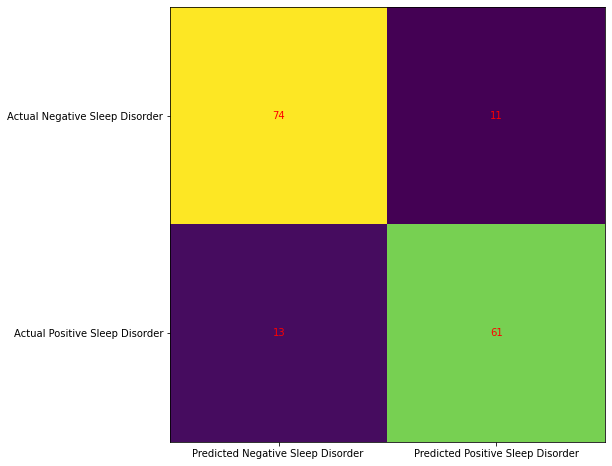

In [455]:
# Generate predictions with the best model. This will return regression values which are continuous
y_pred = model.predict(feature_test)

y_pred_binary = []
for i in y_pred:
    if (i < 0.5) :
        y_pred_binary.append(0)
    else :
        y_pred_binary.append(1)
        
# Create the confusion matrix
cm = confusion_matrix(label_test, y_pred_binary)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Sleep Disorder ', 'Predicted Positive Sleep Disorder'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative Sleep Disorder', 'Actual Positive Sleep Disorder'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [456]:
print(classification_report(label_test, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86        85
         1.0       0.85      0.82      0.84        74

    accuracy                           0.85       159
   macro avg       0.85      0.85      0.85       159
weighted avg       0.85      0.85      0.85       159



# Driver (to run entire experiment over k iterations, if needed)